In [27]:
from pathlib import Path
from neuroginius.atlas import Atlas
from cogpred.loading import TSFetcher, make_training_data

tspath = Path("/georges/memento/BIDS/derivatives/schaeffer200_merged_phenotypes")
atlas = Atlas.from_name("schaefer200")
fetcher = TSFetcher(tspath)
bname = fetcher.rest_dataset.file_path[0]
#bname = "/georges/memento/BIDS/derivatives/fmriprep-23.2.0/sub-0026/ses-M000/func/sub-0026_ses-M000_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz"
bname = "/georges/memento/BIDS/derivatives/fmriprep-23.2.0/sub-0007/ses-M024/func/sub-0007_ses-M024_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz"

In [28]:
from nilearn.interfaces.fmriprep import load_confounds
import nibabel as nib

confounds, sample_mask = load_confounds(bname)

In [29]:
from nilearn.interfaces.bids import parse_bids_filename
import json
def fetch_tr(fpath:Path)->float:
    """Fetches TR of a given scan in the corresponding json sidecar

    Args:
        fpath (Path): Path of the scan file

    Returns:
        float: TR in seconds
    """
    sidecar_path = fpath.parent / fpath.name.replace(".nii.gz", ".json")
    with open(sidecar_path, "r") as stream:
        sidecar = json.load(stream)
    tr = sidecar["RepetitionTime"]
    return tr

tr = fetch_tr(Path(bname))

In [30]:
import numpy as np
time = np.array([tr * i for i in range(len(confounds))])
confounds["time"] = time
coco = [f"cosine0{i}" for i in range(8)]
coco.append("time")
cosines = confounds[coco]

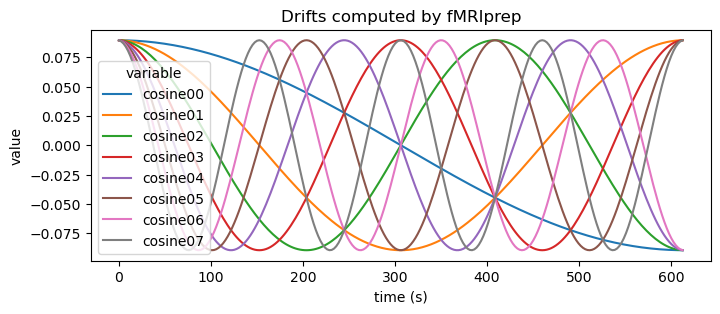

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.subplots(figsize=(8, 3))
sns.lineplot(cosines.melt(id_vars="time"), x="time", y="value", hue="variable")
plt.xlabel("time (s)")
plt.title("Drifts computed by fMRIprep")
plt.show()

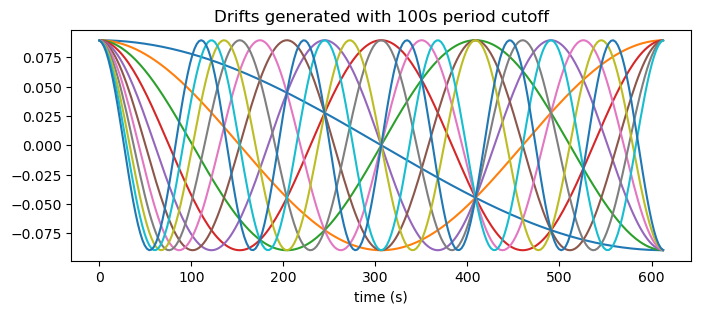

In [32]:
from nipype.algorithms.confounds import _cosine_drift
PCUT = 100 # In seconds
drifts = _cosine_drift(PCUT, time)
plt.subplots(figsize=(8, 3))
plt.plot(time, drifts[:, :-1])
plt.title(f"Drifts generated with {PCUT}s period cutoff")
plt.xlabel("time (s)")
plt.show()

In [33]:
c, _ = load_confounds(bname, strategy=["wm_csf", "motion"])

In [48]:
from nipype.algorithms.confounds import _cosine_drift

def add_drifts(confounds, tr, pcut=100):
    time = np.array([tr * i for i in range(len(confounds))])
    drifts = _cosine_drift(PCUT, time)
    drifts = pd.DataFrame(drifts, columns=[f"cosine{i}" for i in range(drifts.shape[1])])
    return pd.merge(
        c,
        drifts,
        left_index=True,
        right_index=True,
    )

In [49]:
add_drifts(c, tr)

,csf,rot_x,rot_x_derivative1,rot_x_derivative1_power2,rot_x_power2,rot_y,rot_y_derivative1,rot_y_derivative1_power2,rot_y_power2,rot_z,...,cosine2,cosine3,cosine4,cosine5,cosine6,cosine7,cosine8,cosine9,cosine10,cosine11
0,-21.530066,0.006913,-0.000129,-6.383676e-07,-0.000081,0.001223,0.000398,1.472514e-08,-0.000002,-0.000113,...,0.089427,0.089414,0.089399,0.089379,0.089356,0.089330,0.089300,0.089266,0.089229,1.0
1,-23.645495,0.006733,-0.000129,-6.383676e-07,-0.000081,0.001604,0.000398,1.472514e-08,-0.000002,-0.001141,...,0.089300,0.089189,0.089046,0.088871,0.088665,0.088428,0.088159,0.087858,0.087527,1.0
2,-21.246121,0.006859,0.000176,-6.549589e-07,-0.000081,0.001644,0.000056,-1.288150e-07,-0.000002,-0.000906,...,0.089046,0.088737,0.088342,0.087858,0.087289,0.086633,0.085891,0.085065,0.084155,1.0
3,-12.294114,0.006290,-0.000518,-3.471319e-07,-0.000080,0.001611,-0.000015,-1.292999e-07,-0.000002,-0.000815,...,0.088665,0.088062,0.087289,0.086346,0.085237,0.083963,0.082526,0.080930,0.079177,1.0
4,-22.199921,0.006819,0.000580,-3.907936e-07,-0.000081,0.001629,0.000036,-1.300215e-07,-0.000002,-0.000963,...,0.088159,0.087164,0.085891,0.084344,0.082526,0.080445,0.078107,0.075519,0.072690,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.102315,-0.004832,0.000369,-5.692310e-07,0.000069,-0.003124,-0.000153,-1.012750e-07,0.000014,0.003422,...,-0.088159,0.087164,-0.085891,0.084344,-0.082526,0.080445,-0.078107,0.075519,-0.072690,1.0
246,2.433644,-0.005141,-0.000258,-5.756284e-07,0.000077,-0.003250,-0.000108,-1.145836e-07,0.000015,0.003489,...,-0.088665,0.088062,-0.087289,0.086346,-0.085237,0.083963,-0.082526,0.080930,-0.079177,1.0
247,5.378809,-0.004912,0.000279,-6.187254e-07,0.000071,-0.003406,-0.000139,-1.060135e-07,0.000017,0.003314,...,-0.089046,0.088737,-0.088342,0.087858,-0.087289,0.086633,-0.085891,0.085065,-0.084155,1.0
248,7.005291,-0.004925,0.000038,-6.706317e-07,0.000072,-0.003389,0.000034,-1.300916e-07,0.000016,0.003324,...,-0.089300,0.089189,-0.089046,0.088871,-0.088665,0.088428,-0.088159,0.087858,-0.087527,1.0


In [34]:
corr_cosine = np.corrcoef(drifts.T, c.T)
np.fill_diagonal(corr_cosine, 0)

/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [35]:
import pandas as pd
cols = [f"cos_{i}" for i in range(drifts.shape[1])]
cols += list(c.columns)
corrmap = pd.DataFrame(corr_cosine, columns=cols, index=cols)

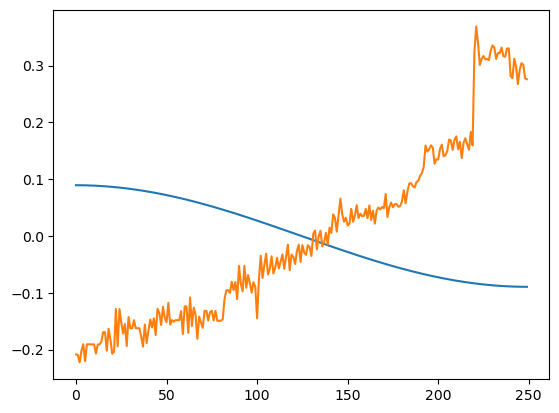

In [36]:
plt.plot(drifts[:, 0])
plt.plot(c.loc[:, "trans_y"])
plt.show()

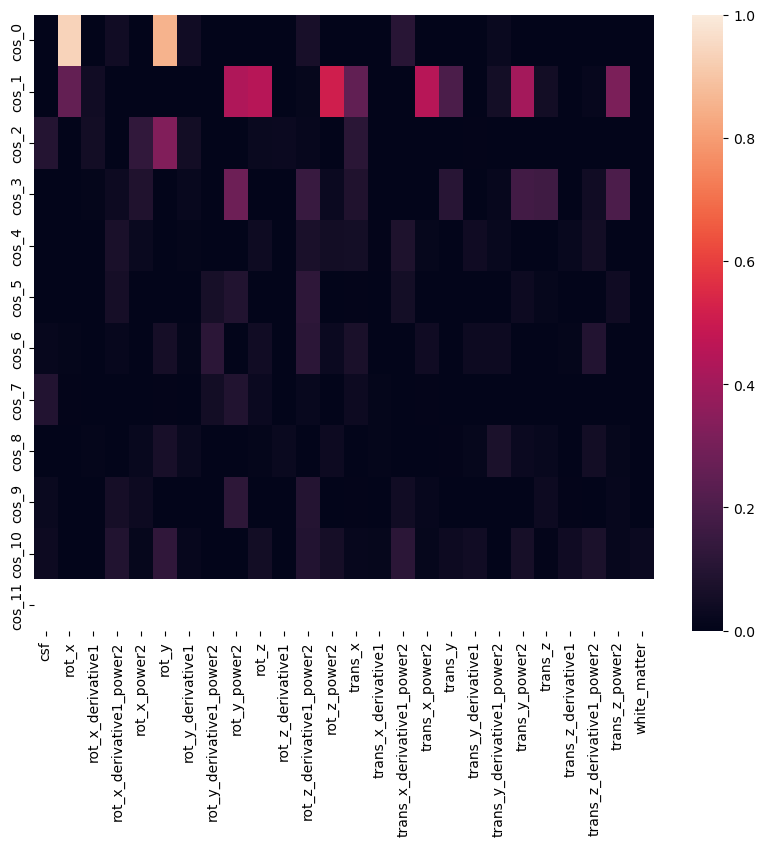

In [38]:
plt.subplots(figsize=(10, 8))
n_cosines = drifts.shape[1]
sns.heatmap(corrmap.iloc[:n_cosines, n_cosines:], vmin=0, vmax=1)
plt.show()

In [12]:
from nilearn.signal import _check_cosine_by_user

_check_cosine_by_user(c, _cosine_drift(PCUT, time)).shape

/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/nilearn/signal.py:921: UserWarning: Cosine filter(s) exist in user supplied confounds.Use user supplied regressors only.
  warnings.warn(


(250, 26)

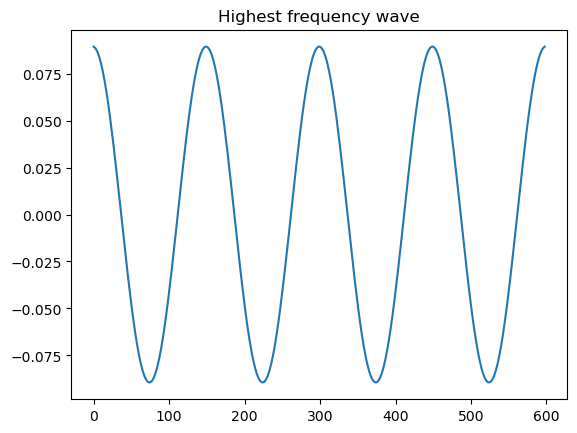

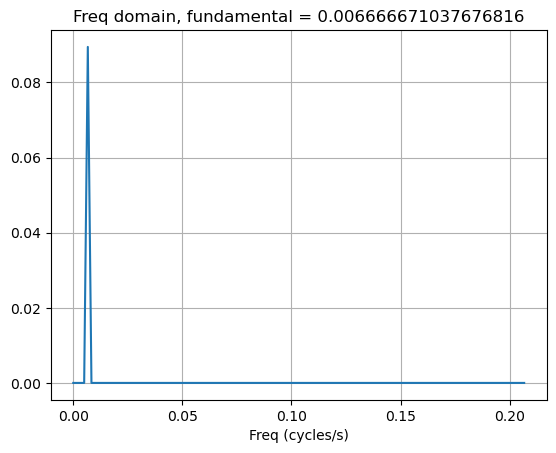

In [13]:
from scipy.fft import rfft, rfftfreq

sig = cosines.iloc[:, 7].values#.sum(axis=1).values
plt.plot(time, sig)
plt.title("Highest frequency wave")
plt.show()

N = len(sig)
yf = rfft(sig)
xf = rfftfreq(N, d=tr)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.xlabel("Freq (cycles/s)")

k_star = np.argmax(yf)
fundamental = xf[k_star]
plt.title(f"Freq domain, fundamental = {fundamental}") # Should be less than 1/PCUT
plt.show()